In [38]:
# importing relevant libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [39]:
# load dataset into dataframe
df = pd.read_csv('raw_data.csv')
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [40]:
df.drop(columns=['date', 'lights'], inplace=True) # drop date and light columns

In [41]:
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [42]:
X = df.iloc[:,1:-2]
scaled = StandardScaler().fit_transform(X)
X = pd.DataFrame(scaled, columns=X.columns) # scale features for variance inflation factor (handling multicolinearity)

In [43]:
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])] # apply VIF
vif['features'] = X.columns
vif = vif.round(2)
to_drop = vif.loc[vif['VIF Factor'] > 5, 'features'].values.tolist() #  pass all features whose VIF scores are greater than 5 into a list

In [44]:
df.drop(columns=to_drop, inplace=True) # drop all features present in the created list

In [45]:
df.head()

,Appliances,RH_5,Press_mm_hg,Windspeed,Visibility,rv1,rv2
0,60,55.20,733.5,7.000000,63.000000,13.275433,13.275433
1,60,55.20,733.6,6.666667,59.166667,18.606195,18.606195
2,50,55.09,733.7,6.333333,55.333333,28.642668,28.642668
3,50,55.09,733.8,6.000000,51.500000,45.410389,45.410389
4,60,55.09,733.9,5.666667,47.666667,10.084097,10.084097


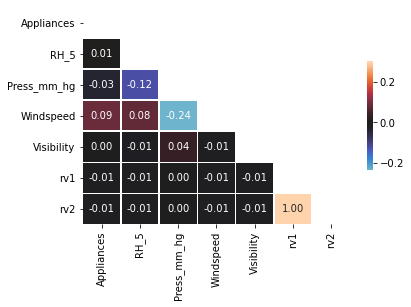

In [46]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', vmax=0.3, center=0, square=False, linewidths=0.5, cbar_kws={'shrink':0.5})

In [47]:
from sklearn import linear_model as lm
from sklearn import preprocessing as prep
from sklearn.pipeline import Pipeline
from sklearn import metrics as mrc
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [48]:
X = df.drop(columns=['Appliances', 'rv1', 'rv2'])
Y = df['Appliances']

In [49]:
# define modeling function

def make_model(model_fn, X, Y, show_plot=False):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    model = model_fn(x_train, y_train)
    y_pred = model.predict(x_test)
    
    if show_plot == True:
        fig, ax = plt.subplots(figsize=(8,5))
        sns.distplot(y_train, hist=False, label='Actual', color='r', ax=ax)
        sns.distplot(y_test, hist=False, label='Predicted', color='g', ax=ax)
        ax.set_title('Appliances')
        plt.show()
    
    return {
            'Training Score': model.score(x_train, y_train),
            'R2 Score': mrc.r2_score(y_pred, y_test),
            'Adjusted R2 Score': 1 - ((1-mrc.r2_score(y_pred, y_test))*(y_test.shape[0] - 1) / (y_test.shape[0] - x_test.shape[1] - 1)),
            'SSRes': np.sum(np.square(y_test - y_pred)),
            'MAE': mrc.mean_absolute_error(y_pred, y_test),
            'MSE': mrc.mean_squared_error(y_pred, y_test, squared=True),
            'RMSE': mrc.mean_squared_error(y_pred, y_test, squared=False),
           }

In [50]:
# create functions for different algorithms/estimators including Polynomial features

def lr_model(x_train, y_train):
    model = Pipeline(steps = [('scaler', prep.MinMaxScaler()), ('estimator', lm.LinearRegression(normalize=True))]).fit(x_train, y_train)
    return model

def lasso_model(x_train, y_train):
    model = Pipeline(steps = [('scaler', prep.MinMaxScaler()), ('estimator', lm.Lasso())]).fit(x_train, y_train)
    return model

def ridge_model(x_train, y_train):
    model = Pipeline(steps = [('scaler', prep.MinMaxScaler()), ('estimator', lm.Ridge())]).fit(x_train, y_train)
    return model

def elastic_model(x_train, y_train):
    model = Pipeline(steps = [('scaler', prep.MinMaxScaler()), ('estimator', lm.ElasticNet(l1_ratio=0.5))]).fit(x_train, y_train)
    return model

def sgd_model(x_train, y_train):
    model = Pipeline(steps = [('scaler', prep.MinMaxScaler()), ('estimator', lm.SGDRegressor(max_iter=10000, tol=0.003))]).fit(x_train, y_train)
    return model

def dt_model(x_train, y_train):
    model = Pipeline(steps = [('scaler', prep.MinMaxScaler()), ('estimator', DecisionTreeRegressor(max_depth=9))]).fit(x_train, y_train)
    return model

def svr_model(x_train, y_train):
    model = Pipeline(steps = [('scaler', prep.MinMaxScaler()), ('estimator', SVR(kernel='poly', tol=0.003))]).fit(x_train, y_train)
    return model

In [51]:
# pass metric results into a dataframe
result_dict = {}
result_dict['Linear Regression'] = make_model(lr_model, X, Y)
result_dict['Lasso Regression'] = make_model(lasso_model, X, Y)
result_dict['Ridge Regression'] = make_model(ridge_model, X, Y)
result_dict['Elastic Net'] = make_model(elastic_model, X, Y)
result_dict['SGD Regression'] = make_model(sgd_model, X, Y)
result_dict['SV Regression'] = make_model(svr_model, X, Y)
result = pd.DataFrame(result_dict).transpose()
result

,Training Score,R2 Score,Adjusted R2 Score,SSRes,MAE,MSE,RMSE
Linear Regression,0.007633,-122.350375,-122.433776,6.050256e+07,60.109211,10218.301326,101.085614
Lasso Regression,0.004355,-1001.837181,-1002.515231,6.072059e+07,60.286350,10255.124290,101.267588
Ridge Regression,0.007633,-122.903870,-122.987646,6.050254e+07,60.109307,10218.297867,101.085597
Elastic Net,0.000579,-81927.956387,-81983.351219,6.096432e+07,60.451602,10296.287696,101.470625
SGD Regression,0.007148,-121.058491,-121.141019,6.053171e+07,59.013839,10223.224604,101.109963
SV Regression,-0.099588,-141.975164,-142.071834,6.690920e+07,48.946973,11300.321138,106.302969


In [52]:
# create a new dataframe to use all features for modeling without removing colineared features.
df_new = pd.read_csv('raw_data.csv').drop(columns=['date', 'lights', 'rv1', 'rv2'])

In [53]:
X = df_new.drop('Appliances', axis=1)
Y = df_new['Appliances']

In [54]:
# pass result of metrics into a dataframe
%matplotlib inline
result_dict = {}
result_dict['Linear Regression'] = make_model(lr_model, X, Y)
result_dict['Lasso Regression'] = make_model(lasso_model, X, Y)
result_dict['Ridge Regression'] = make_model(ridge_model, X, Y)
result_dict['Elastic Net'] = make_model(elastic_model, X, Y)
result_dict['SGD Regression'] = make_model(sgd_model, X, Y)
result_dict['SV Regression'] = make_model(svr_model, X, Y)
result = pd.DataFrame(result_dict).transpose()
result

,Training Score,R2 Score,Adjusted R2 Score,SSRes,MAE,MSE,RMSE
Linear Regression,0.144698,-4.413325,-4.435361,5.190000e+07,53.638811,8765.411549,93.623777
Lasso Regression,0.038730,-74.189104,-74.495166,5.853013e+07,58.353788,9885.177298,99.424229
Ridge Regression,0.143905,-4.835653,-4.859407,5.197731e+07,53.567288,8778.468737,93.693483
Elastic Net,0.007398,-1464.425650,-1470.390748,6.049650e+07,60.042992,10217.277293,101.080549
SGD Regression,0.127018,-6.965350,-6.997774,5.316747e+07,53.222527,8979.475149,94.760093
SV Regression,0.068764,-16.784964,-16.857358,5.684870e+07,42.219439,9601.199919,97.985713


In [63]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

In [ ]:
est = RandomForestRegressor()
rfe = RFE(est, 4).fit(X, Y)

In [85]:
fs = pd.DataFrame()
fs['Features'] = X.columns
fs['Rank'] = rfe.ranking_
fs['Selected'] = rfe.support_
lst = fs.loc[fs['Selected'] == True]['Features'].values
X[lst].corr()

,RH_2,RH_5,RH_7,Press_mm_hg
RH_2,1.000000,0.250271,0.690584,-0.255646
RH_5,0.250271,1.000000,0.325808,-0.119327
RH_7,0.690584,0.325808,1.000000,-0.265850
Press_mm_hg,-0.255646,-0.119327,-0.265850,1.000000


In [87]:
X_new = X[lst]

In [89]:
# pass result of metrics into a dataframe
%matplotlib inline
result_dict = {}
result_dict['Linear Regression'] = make_model(lr_model, X_new, Y)
result_dict['Lasso Regression'] = make_model(lasso_model, X_new, Y)
result_dict['Ridge Regression'] = make_model(ridge_model, X_new, Y)
result_dict['Elastic Net'] = make_model(elastic_model, X_new, Y)
result_dict['SGD Regression'] = make_model(sgd_model, X_new, Y)
result_dict['SV Regression'] = make_model(svr_model, X_new, Y)
result = pd.DataFrame(result_dict).transpose()
result

,Training Score,R2 Score,Adjusted R2 Score,SSRes,MAE,MSE,RMSE
Linear Regression,0.006884,-1.388113e+02,-1.389058e+02,6.041379e+07,59.930894,10203.308289,101.011427
Lasso Regression,0.000000,-5.101617e+31,-5.105066e+31,6.100189e+07,60.479910,10302.633555,101.501889
Ridge Regression,0.006884,-1.398260e+02,-1.399212e+02,6.041441e+07,59.931337,10203.412499,101.011942
Elastic Net,0.000231,-2.767982e+05,-2.769853e+05,6.098483e+07,60.463291,10299.751766,101.487693
SGD Regression,0.005866,-2.216848e+02,-2.218353e+02,6.052299e+07,59.164203,10221.750690,101.102674
SV Regression,-0.092752,-1.217669e+02,-1.218499e+02,6.654909e+07,48.720548,11239.501768,106.016516
